# Fully convolutional Networks for Semantic Segmentation
https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf

In [0]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
from torchvision import models
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from PIL import Image
from collections import Counter
from sklearn.metrics import jaccard_score

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive





## Dataset : Pascal VOC 2012

In [0]:
# delete folder if exists
!rm -rf /tmp/voc2012
print('rm done.')

rm done.


In [0]:
dataroot = '/tmp/voc2012'



In [0]:


def change_type_input(img):
  return img.float()

def to_tensor_target(img):
  img = np.array(img)
  # border
  img[img==255] = 0 # border = background 
  return torch.LongTensor(img)


In [0]:
train_dataset = dset.VOCSegmentation(dataroot,year='2012', image_set='train', download=True,transform=transforms.Compose([
                                               transforms.Resize((224,224)),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                               #transforms.Lambda(rotate_Tensor),
                                               #transforms.Lambda(change_type_input)
                                           ]),target_transform=transforms.Compose([
                                               transforms.Resize((224,224)),
                                               transforms.Lambda(to_tensor_target)
                                           ]))

val_dataset = dset.VOCSegmentation(dataroot,year='2012', image_set='val', download=True,transform=transforms.Compose([
                                               transforms.Resize((224,224)),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                               #transforms.Lambda(rotate_Tensor),
                                               #transforms.Lambda(change_type_input)
                                           ]),target_transform=transforms.Compose([
                                               transforms.Resize((224,224)),
                                               transforms.Lambda(to_tensor_target)
                                           ]))

Using downloaded and verified file: /tmp/voc2012/VOCtrainval_11-May-2012.tar


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
torch.Size([3, 224, 224])
torch.Size([224, 224, 3])


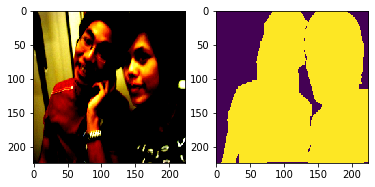

In [0]:
"""Pascal VOC Dataset Segmentation Dataloader"""


VOC_CLASSES = ('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor')

NUM_CLASSES = len(VOC_CLASSES) + 1



sample = val_dataset.__getitem__(7)
image, mask = sample[0], sample[1]
print(type(image))
print(image.size())
image.transpose_(0, 2)
image.transpose_(0, 1)
print(image.size())

fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(image)    #.transpose(0,1)

a = fig.add_subplot(1,2,2)
plt.imshow(mask)

plt.show()

In [0]:

# Set batch_size
batch_size = 20

dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
#dataloader_train_val = torch.utils.data.DataLoader(trainval_dataset, batch_size=batch_size)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device :",device)



device : cuda:0


In [0]:
print("Taille dataset train :",len(train_dataset))
print("Taille dataset val :",len(val_dataset))

Taille dataset train : 1464
Taille dataset val : 1449


## Metric code

In [0]:
SMOOTH = 1e-6
def iou(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W

    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    
    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    #iou_metric = ((iou-0.5)*2*10).floor()/10
    #iou_metric[iou_metric<0] = 0

    return iou.mean()  # Or thresholded.mean() if you are interested in average across the batch
    


 
iou(next(iter(dataloader_train))[1],next(iter(dataloader_val))[1])

tensor(0.0805)

In [0]:
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) + label_pred[mask],
        minlength=n_class ** 2,
    ).reshape(n_class, n_class)
    return hist


def scores(label_trues, label_preds, n_class=21):
    label_trues = label_trues.cpu().numpy()
    label_preds = label_preds.cpu().numpy()
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    valid = hist.sum(axis=1) > 0  # added
    mean_iu = np.nanmean(iu[valid])
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    cls_iu = dict(zip(range(n_class), iu))

    return {
        "Pixel Accuracy": acc,
        "Mean Accuracy": acc_cls,
        "Frequency Weighted IoU": fwavacc,
        "Mean IoU": mean_iu,
        "Class IoU": cls_iu,
    }

In [0]:
def evaluate_model(model,val_loader,criterion=nn.CrossEntropyLoss(ignore_index=21),nclass=21):
  loss_test = []
  iou_test = []
  pixel_accuracy = []
  weight_iou = []
  with torch.no_grad():
    for i,(x,mask) in enumerate(dataloader_val):
          x = x.to(device)
          mask = mask.to(device)

          model.eval()
          pred = model(x)


          loss = criterion(pred,mask)
          loss_test.append(loss.item())
          
          s = scores(pred.max(dim=1)[1],mask)
          ioU = float(iou(pred.argmax(dim=1),mask))
          """
            return {
              "Pixel Accuracy": acc,
              "Mean Accuracy": acc_cls,
              "Frequency Weighted IoU": fwavacc,
              "Mean IoU": mean_iu,
              "Class IoU": cls_iu,
          }
          """
          iou_test.append(ioU)
          pixel_accuracy.append(s["Pixel Accuracy"])
          weight_iou.append(s["Frequency Weighted IoU"])

    

    print("Mean IOU :",np.array(iou_test).mean(),"Frequency Weighted IOU :",np.array(weight_iou).mean(),\
          "Pixel Accuracy :",np.array(pixel_accuracy).mean(),"Loss Validation :",np.array(loss_test).mean())


## FCN for Semantic Segmentation models

In [0]:
print('Instanciation de VGG16')
vgg16 = models.vgg16(pretrained=True)
vgg16

Instanciation de VGG16


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
class FCN32_VGG16(torch.nn.Module): # Archi FCN-32s du papier
    def __init__(self,vgg16):
        super(FCN32_VGG16,self).__init__()
        self.features_im_net = nn.Sequential(*list(vgg16.features.children()))
        # On ne considère que les features et on supprime les couches fully connected.
        # pour les remplacer par des conv 
        # on ne garde pas l'avg pool
        # [512,7,7]
        
        self.conv1 = nn.Conv2d(512, 4096, 7,padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout()
        self.conv2 = nn.Conv2d(4096,4096,kernel_size=(1,1),padding=0)
        self.conv3 = nn.Conv2d(4096,21,kernel_size=(1,1),padding=0)

        
        fc1 = vgg16.classifier[0].state_dict()


        

        ### get the weights from the fc layer
        #self.conv1.load_state_dict({"weight":fc1["weight"].view(4096, 512, 7, 7),
         #                         "bias":fc1["bias"]})



        self.conv1.weight = nn.Parameter(vgg16.classifier[0].weight.view(4096,512,7,7))
        self.conv1.bias = vgg16.classifier[0].bias
        self.conv2.weight = nn.Parameter(vgg16.classifier[3].weight.unsqueeze(2).unsqueeze(3))
        self.conv2.bias = vgg16.classifier[3].bias


        self.upsampling = nn.Sequential(
            #nn.ConvTranspose2d(21,1,kernel_size=(7,7)), # Pas sur mais pour augmenter d'un facteur 32 pour arriver à 224
            #, il nous faut des fmaps de taille 7 #Pas sur pour dim_out =1 non plus.
            nn.UpsamplingBilinear2d(scale_factor=32)#,
            #nn.Sigmoid()

        )
        


    def forward(self,x):
        x = self.features_im_net(x)
        x = self.conv1(x)
        #print("after conv1 ",x.size())
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        #print("after conv2 ",x.size())
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.conv3(x)
        #print("after conv3 ",x.size())
        x = self.upsampling(x)  
        #print("after upsampling ",x.size())
        return x # [224,224]

In [0]:
fcn32 = FCN32_VGG16(vgg16)
fcn32.to(device)

FCN32_VGG16(
  (features_im_net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


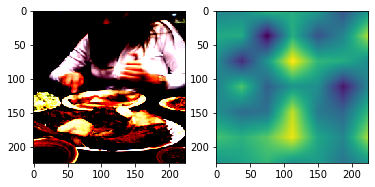

In [0]:

batch_test = next(iter(dataloader_train))
output_f = fcn32(batch_test[0].to(device))




fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(batch_test[0][0].transpose(0,2).transpose(0,1).cpu())

a = fig.add_subplot(1,2,2)
plt.imshow(output_f[0][0].cpu().detach().numpy())

plt.show()

## Training

In [0]:
learning_rate = 10e-4
moment = 0.9
optimizer = torch.optim.SGD(fcn32.parameters(),lr=learning_rate,momentum=moment, weight_decay=2e-4)
n_epochs = 175
#writer = SummaryWriter()
criterion = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.

EPOCH 0


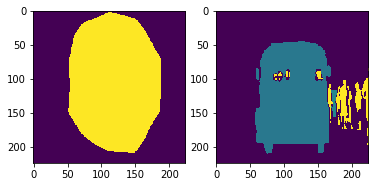

Classe prédite :  ['background', 'bus']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
EPOCH 17
EPOCH 18
EPOCH 19
EPOCH 20


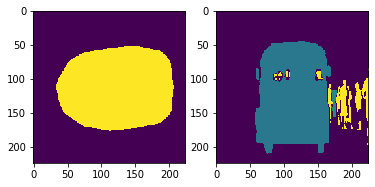

Classe prédite :  ['background', 'bus']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 21
EPOCH 22
EPOCH 23
EPOCH 24
EPOCH 25
EPOCH 26
EPOCH 27
EPOCH 28
EPOCH 29
EPOCH 30
EPOCH 31
EPOCH 32
EPOCH 33
EPOCH 34
EPOCH 35
EPOCH 36
EPOCH 37
EPOCH 38
EPOCH 39
EPOCH 40


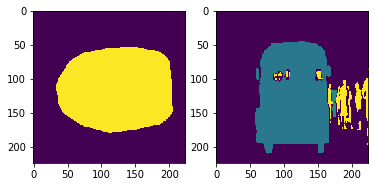

Classe prédite :  ['background', 'bus']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 41
EPOCH 42
EPOCH 43
EPOCH 44
EPOCH 45
EPOCH 46
EPOCH 47
EPOCH 48
EPOCH 49
EPOCH 50
EPOCH 51
EPOCH 52
EPOCH 53
EPOCH 54
EPOCH 55
EPOCH 56
EPOCH 57
EPOCH 58
EPOCH 59
EPOCH 60


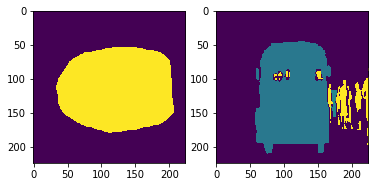

Classe prédite :  ['background', 'bus']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 61
EPOCH 62
EPOCH 63
EPOCH 64
EPOCH 65
EPOCH 66
EPOCH 67
EPOCH 68
EPOCH 69
EPOCH 70
EPOCH 71
EPOCH 72
EPOCH 73
EPOCH 74
EPOCH 75
EPOCH 76
EPOCH 77
EPOCH 78
EPOCH 79
EPOCH 80


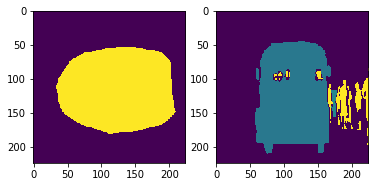

Classe prédite :  ['background', 'bus']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 81
EPOCH 82
EPOCH 83
EPOCH 84
EPOCH 85
EPOCH 86
EPOCH 87
EPOCH 88
EPOCH 89
EPOCH 90
EPOCH 91
EPOCH 92
EPOCH 93
EPOCH 94
EPOCH 95
EPOCH 96
EPOCH 97
EPOCH 98
EPOCH 99
EPOCH 100


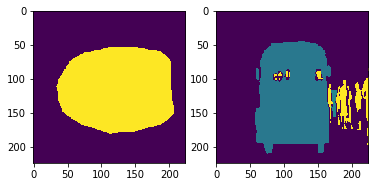

Classe prédite :  ['background', 'bus']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 101
EPOCH 102
EPOCH 103
EPOCH 104
EPOCH 105
EPOCH 106
EPOCH 107
EPOCH 108
EPOCH 109
EPOCH 110
EPOCH 111
EPOCH 112
EPOCH 113
EPOCH 114
EPOCH 115
EPOCH 116
EPOCH 117
EPOCH 118
EPOCH 119
EPOCH 120


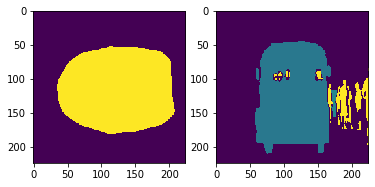

Classe prédite :  ['background', 'bus']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 121
EPOCH 122
EPOCH 123
EPOCH 124
EPOCH 125
EPOCH 126
EPOCH 127
EPOCH 128
EPOCH 129
EPOCH 130
EPOCH 131
EPOCH 132
EPOCH 133
EPOCH 134
EPOCH 135
EPOCH 136
EPOCH 137
EPOCH 138
EPOCH 139
EPOCH 140


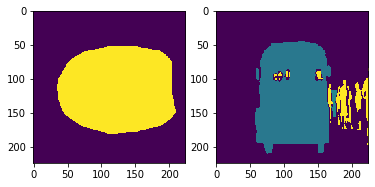

Classe prédite :  ['background', 'bus']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 141
EPOCH 142
EPOCH 143
EPOCH 144
EPOCH 145
EPOCH 146
EPOCH 147
EPOCH 148
EPOCH 149
EPOCH 150
EPOCH 151
EPOCH 152
EPOCH 153
EPOCH 154
EPOCH 155
EPOCH 156
EPOCH 157
EPOCH 158
EPOCH 159
EPOCH 160


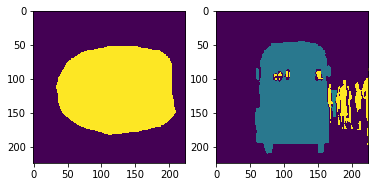

Classe prédite :  ['background', 'bus']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 161
EPOCH 162
EPOCH 163
EPOCH 164
EPOCH 165
EPOCH 166
EPOCH 167
EPOCH 168
EPOCH 169
EPOCH 170
EPOCH 171
EPOCH 172
EPOCH 173
EPOCH 174


In [0]:
SAVE_DIR = '/tmp/model'
iou_train = []
loss_train = []
iou_test = []
loss_test = []
all_loss_train = []
all_loss_test = []
all_iou = []
for ep in range(n_epochs):
    print("EPOCH",ep)

    for i,(x,mask) in enumerate(dataloader_train):
          x = x.to(device)
          mask = mask.to(device)

          fcn32.train()
          pred = fcn32(x)
          #pred = pred.squeeze()
          #mask = mask.squeeze()

          #print('i =',i)

          loss = criterion(pred,mask)
          all_loss_train.append(loss.item())
          loss.backward()

          all_iou.append(float(iou(pred.argmax(dim=1),mask)))

          optimizer.step()
          optimizer.zero_grad()

    loss_train.append(np.array(all_loss_train).mean()) #.item() pour eviter fuite memoire
    iou_train.append(np.array(all_iou).mean())
    all_loss_train = []
    all_iou = []
    for i,(x,mask) in enumerate(dataloader_val):
          x = x.to(device)
          mask = mask.to(device)

          fcn32.eval()
          with torch.no_grad():
            pred = fcn32(x)
          #pred = pred.squeeze()
          #mask = mask.squeeze()

          loss = criterion(pred,mask)
          all_loss_test.append(loss.item())
          all_iou.append(float(iou(pred.argmax(dim=1),mask)))
      
    loss_test.append(np.array(all_loss_test).mean())
    iou_test.append(np.array(all_iou).mean())
    all_loss_test = []
    all_iou = []

    if ep%20==0:
      try:
        i = 0
        fig = plt.figure()

        a = fig.add_subplot(1,2,1)
        plt.imshow(np.transpose(pred.argmax(dim=1)[i].cpu()))

        a = fig.add_subplot(1,2,2)
        plt.imshow(mask.cpu().detach().numpy()[i])

        plt.show()
        class_pred = []
        class_mask = []

        for p in pred.argmax(dim=1)[i].unique():
          class_pred.append(VOC_CLASSES[int(p)])
        for m in mask[i].unique():
          class_mask.append(VOC_CLASSES[int(m)])

        print("Classe prédite : ",class_pred)
        print("Classe réelle : ",class_mask)
      except:
        print('something with the plot image function')
        
    

In [0]:
torch.save(fcn32,'/content/drive/My Drive/segmentation/fc32.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FCN32_VGG16. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
fcn32=torch.load('/content/drive/My Drive/segmentation/fc32.pt')

## Plot

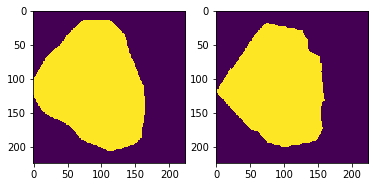

Classe prédite :  ['background', 'train']
Classe réelle :  ['background', 'train']
0.9389748086734694
IOU sur ce masque : 0.864224910736084


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [0]:
x,mask = next(iter(dataloader_val))
i = 3
x = x.to(device)
mask = mask.to(device)
pred = fcn32(x)
fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(pred.max(dim=1)[1][i].cpu())

a = fig.add_subplot(1,2,2)
plt.imshow(mask.cpu().detach().numpy()[i])

plt.show()

class_pred = []
class_mask = []

for p in pred.argmax(dim=1)[i].unique():
  class_pred.append(VOC_CLASSES[int(p)])
for m in mask[i].unique():
  class_mask.append(VOC_CLASSES[int(m)])

print("Classe prédite : ",class_pred)
print("Classe réelle : ",class_mask)
print(scores(pred.argmax(dim=1)[i],mask[i])["Pixel Accuracy"])
print("IOU sur ce masque :",float(iou(pred.argmax(dim=1)[i].unsqueeze(0),mask[i].unsqueeze(0))))


Text(0, 0.5, 'Mean IOU')

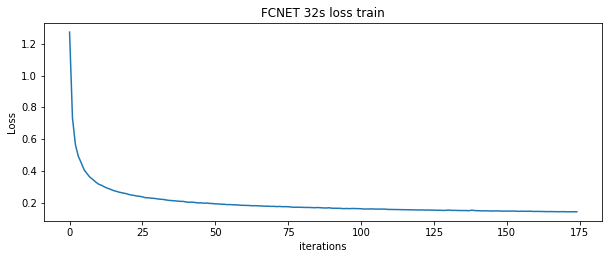

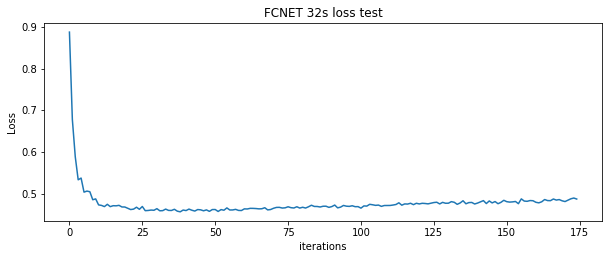

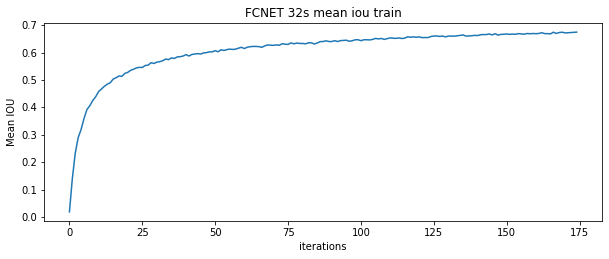

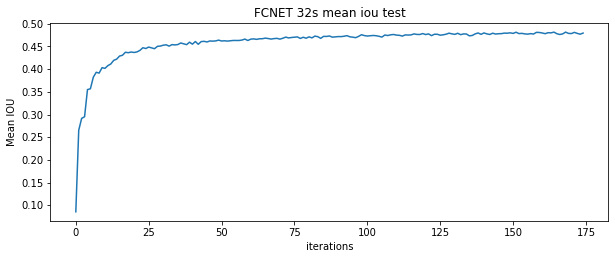

In [0]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 32s loss train")
plt.plot(loss_train)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 32s loss test")
plt.plot(loss_test)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 32s mean iou train")
plt.plot(iou_train)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 32s mean iou test")
plt.plot(iou_test)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")

In [0]:
evaluate_model(fcn32,dataloader_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Mean IOU : 0.47943890298882574 Frequency Weighted IOU : 0.7841624289870064 Pixel Accuracy : 0.8590072594391638 Loss Validation : 0.4873690229572662


## Implémentation de la variante FCN-16s 

In [0]:
class FCN16_VGG16(torch.nn.Module): # Archi FCN-16s du papier
    def __init__(self,fcn32):
        super(FCN16_VGG16,self).__init__()
        
        self.features_pool4 = nn.Sequential(*list(fcn32.features_im_net.children())[:24]) # Features coupé à la couche pool4
        self.features_fc32 = nn.Sequential(*list(fcn32.features_im_net.children())[24:]) # Features complet de fc32
        # Classifieur FCN32
        self.conv1 = nn.Conv2d(512, 4096, 7,padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout()
        self.conv2 = nn.Conv2d(4096,4096,kernel_size=(1,1),padding=0)
        self.conv3 = nn.Conv2d(4096,21,kernel_size=(1,1),padding=0)
        
        # Copy Weight of FCN32
        self.conv1.weight = nn.Parameter(fcn32.conv1.weight)
        self.conv1.bias = fcn32.conv1.bias
        self.conv2.weight = nn.Parameter(fcn32.conv2.weight)
        self.conv2.bias = fcn32.conv2.bias
        self.conv3.weight = nn.Parameter(fcn32.conv3.weight)
        self.conv3.bias = fcn32.conv3.bias

        # Classifieur branche FCN16

        self.conv_fc16 = nn.Conv2d(512,21,kernel_size=(1,1)) # [14,14]
        

        # Upsampling
        self.final_upsampling = nn.UpsamplingBilinear2d(scale_factor=16)
        self.combine_classif_upsampling = nn.UpsamplingBilinear2d(scale_factor=2)
        


    def forward(self,x):
        x = self.features_pool4(x)
        # branche fc32
        x1 = self.features_fc32(x)
        x1 = self.conv1(x1)
        x1 = self.relu1(x1)
        x1 = self.dropout(x1)
        x1 = self.conv2(x1)
        x1 = self.relu2(x1)
        x1 = self.dropout(x1)
        x1 = self.conv3(x1) # [7,7]
        x1 = self.combine_classif_upsampling(x1) # [14,14]
        
        # branche fc16
        x2 = self.conv_fc16(x)

        # Somme des classifieurs
        x = x1+x2 
        mask = self.final_upsampling(x)  

        return mask # [224,224]

In [0]:
fcn16 = FCN16_VGG16(fcn32) # Comme l'article on réentraine sur fc32
fcn16.to(device)

FCN16_VGG16(
  (features_pool4): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding

### Training

In [0]:
learning_rate = 10e-4
moment = 0.9
optimizer = torch.optim.SGD(fcn16.parameters(),lr=learning_rate,weight_decay=2e-4,momentum=moment)
n_epochs = 175
#writer = SummaryWriter()
criterion = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.

EPOCH 0


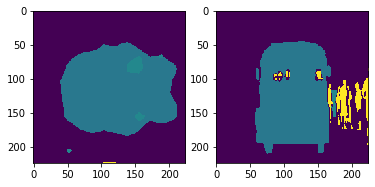

Classe prédite :  ['background', 'bus', 'car', 'person']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
EPOCH 17
EPOCH 18
EPOCH 19
EPOCH 20


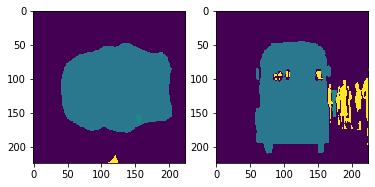

Classe prédite :  ['background', 'bus', 'car', 'person']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 21
EPOCH 22
EPOCH 23
EPOCH 24
EPOCH 25
EPOCH 26
EPOCH 27
EPOCH 28
EPOCH 29
EPOCH 30
EPOCH 31
EPOCH 32
EPOCH 33
EPOCH 34
EPOCH 35
EPOCH 36
EPOCH 37
EPOCH 38
EPOCH 39
EPOCH 40


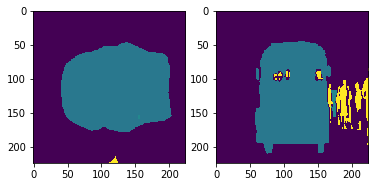

Classe prédite :  ['background', 'bus', 'car', 'person']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 41
EPOCH 42
EPOCH 43
EPOCH 44
EPOCH 45
EPOCH 46
EPOCH 47
EPOCH 48
EPOCH 49


In [0]:
SAVE_DIR = '/tmp/model'
iou_train = []
loss_train = []
iou_test = []
loss_test = []
all_loss_train = []
all_loss_test = []
all_iou = []
for ep in range(n_epochs):
    print("EPOCH",ep)

    for i,(x,mask) in enumerate(dataloader_train):
          x = x.to(device)
          mask = mask.to(device)

          fcn16.train()
          pred = fcn16(x)
          #pred = pred.squeeze()
          #mask = mask.squeeze()

          #print('i =',i)

          loss = criterion(pred,mask)
          all_loss_train.append(loss.item())
          loss.backward()

          all_iou.append(float(iou(pred.argmax(dim=1),mask)))

          optimizer.step()
          optimizer.zero_grad()

    loss_train.append(np.array(all_loss_train).mean()) #.item() pour eviter fuite memoire
    iou_train.append(np.array(all_iou).mean())
    all_loss_train = []
    all_iou = []
    for i,(x,mask) in enumerate(dataloader_val):
          x = x.to(device)
          mask = mask.to(device)

          fcn16.eval()
          with torch.no_grad():
            pred = fcn16(x)
          #pred = pred.squeeze()
          #mask = mask.squeeze()

          loss = criterion(pred,mask)
          all_loss_test.append(loss.item())
          all_iou.append(float(iou(pred.argmax(dim=1),mask)))
      
    loss_test.append(np.array(all_loss_test).mean())
    iou_test.append(np.array(all_iou).mean())
    all_loss_test = []
    all_iou = []

    if ep%20==0:
      try:
        i = 0
        fig = plt.figure()

        a = fig.add_subplot(1,2,1)
        plt.imshow(np.transpose(pred.argmax(dim=1)[i].cpu()))

        a = fig.add_subplot(1,2,2)
        plt.imshow(mask.cpu().detach().numpy()[i])

        plt.show()
        class_pred = []
        class_mask = []

        for p in pred.argmax(dim=1)[i].unique():
          class_pred.append(VOC_CLASSES[int(p)])
        for m in mask[i].unique():
          class_mask.append(VOC_CLASSES[int(m)])

        print("Classe prédite : ",class_pred)
        print("Classe réelle : ",class_mask)
      except:
        print('something with the plot image function')
        
    

In [0]:
torch.save(fcn16, '/content/drive/My Drive/segmentation/fc16.pt')

In [0]:
fcn16 = torch.load('/content/drive/My Drive/segmentation/fc16.pt')

### Plot

In [0]:
x,mask = next(iter(dataloader_val))
i = 3
x = x.to(device)
mask = mask.to(device)
pred = fcn16(x)
fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(pred.max(dim=1)[1][i].cpu())

a = fig.add_subplot(1,2,2)
plt.imshow(mask.cpu().detach().numpy()[i])

plt.show()

class_pred = []
class_mask = []

for p in pred.argmax(dim=1)[i].unique():
  class_pred.append(VOC_CLASSES[int(p)])
for m in mask[i].unique():
  class_mask.append(VOC_CLASSES[int(m)])

print("Classe prédite : ",class_pred)
print("Classe réelle : ",class_mask)
print(scores(pred.argmax(dim=1)[i],mask[i])["Pixel Accuracy"])
print("IOU sur ce masque :",float(iou(pred.argmax(dim=1)[i].unsqueeze(0),mask[i].unsqueeze(0))))


Text(0, 0.5, 'Mean IOU')

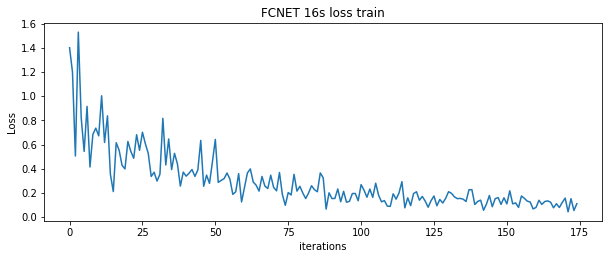

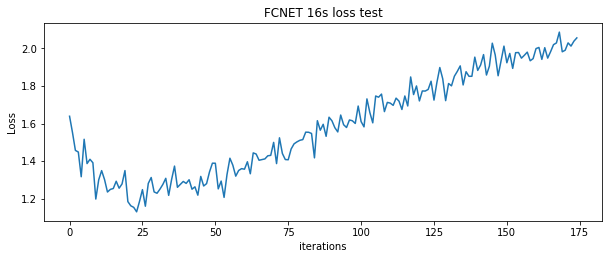

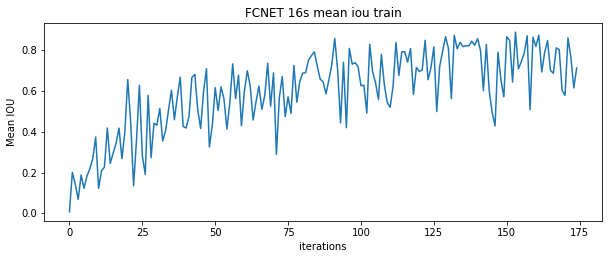

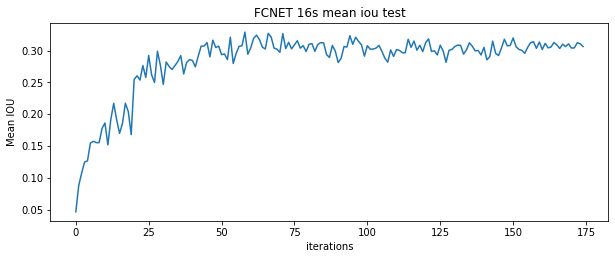

In [0]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 16s loss train")
plt.plot(loss_train)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 16s loss test")
plt.plot(loss_test)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 16s mean iou train")
plt.plot(iou_train)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 16s mean iou test")
plt.plot(iou_test)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")

In [0]:
x,mask = next(iter(dataloader_val))
x = x.to(device)
mask = mask.to(device)
pred = fcn16(x)


fig = plt.figure()
i = 7
a = fig.add_subplot(1,2,1)
plt.imshow(np.transpose(pred.max(dim=1)[1][i].cpu()))

a = fig.add_subplot(1,2,2)
plt.imshow(mask.cpu().detach().numpy()[i])

plt.show()

class_pred = []
class_mask = []

for p in pred.max(dim=1)[1][i].unique():
  class_pred.append(VOC_CLASSES[int(p)])
for m in mask[i].unique():
  class_mask.append(VOC_CLASSES[int(m)])

print("Classe prédite : ",class_pred)
print("Classe réelle : ",class_mask)

In [0]:
evaluate_model(fcn16,dataloader_val)

### Implémentation de la variante FCN-8s

In [0]:
class FCN8_VGG16(torch.nn.Module): # Archi FCN-8s du papier
    def __init__(self,fcn16):
        super(FCN8_VGG16,self).__init__()
        self.features_pool3 = nn.Sequential(*list(fcn16.features_pool4.children())[:17]) # Features coupé à la couche pool3
        self.features_pool4 = nn.Sequential(*list(fcn16.features_pool4.children())[17:24]) # Features coupé à la couche pool4
        self.features_fc32 = nn.Sequential(*list(fcn16.features_fc32.children())) # Features complet de fc32
        # Classifieur FCN32
        self.conv1 = nn.Conv2d(512, 4096, 7, padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout()
        self.conv2 = nn.Conv2d(4096,4096,kernel_size=(1,1),padding=0)
        self.conv3 = nn.Conv2d(4096,21,kernel_size=(1,1),padding=0)

        # Copy weight from classifier
        self.conv1.weight = nn.Parameter(fcn16.conv1.weight)
        self.conv1.bias = fcn16.conv1.bias
        self.conv2.weight = nn.Parameter(fcn16.conv2.weight)
        self.conv2.bias = fcn16.conv2.bias
        self.conv3.weight = nn.Parameter(fcn16.conv3.weight)
        self.conv3.bias = fcn16.conv3.bias

        # Classifieur branche FCN16

        self.conv_fc16 = nn.Conv2d(512,21,kernel_size=(1,1)) # [14,14]

        # Classifieur branche FCN8

        self.conv_fc8 = nn.Conv2d(256,21,kernel_size=(1,1)) # [28,28]
        

        # Upsampling
        self.final_upsampling = nn.UpsamplingBilinear2d(scale_factor=8)
        self.combine_classif_upsampling = nn.UpsamplingBilinear2d(scale_factor=2)
        


    def forward(self,x):
        x0 = self.features_pool3(x)
        # branche fc32 et fc16
        x1 = self.features_pool4(x0)

        # branche fc32
        x2 = self.features_fc32(x1)
        x2 = self.conv1(x2)
        x2 = self.relu1(x2)
        x2 = self.dropout(x2)
        x2 = self.conv2(x2)
        x2 = self.relu2(x2)
        x2 = self.dropout(x2)
        x2 = self.conv3(x2) # [7,7]
        x2 = self.combine_classif_upsampling(x2) # [14,14]
        
        # branche fc16
        x3 = self.conv_fc16(x1) # [14,14]

        # branche fc8
        x4 = self.conv_fc8(x0) # [28,28]

        # Somme des classifieurs fc16 et fc32
        x5 = x2+x3 # [14,14]
        x5 = self.combine_classif_upsampling(x5) # [28,28]

        # somme des classifieurs fc8 et fc16+32
        x6 = x5 + x4

        mask = self.final_upsampling(x6)  

        return mask # [224,224]

In [0]:
fcn8 = FCN8_VGG16(fcn16) # Comme l'article on réentraine sur fc16
fcn8.to(device)

FCN8_VGG16(
  (features_pool3): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


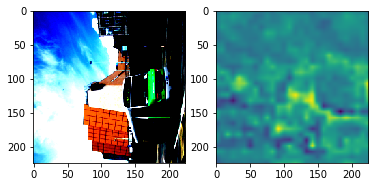

In [0]:
batch_test = next(iter(dataloader_train))[0]
output_f = fcn8(batch_test.to(device))




fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(np.transpose(batch_test[0].cpu()))

a = fig.add_subplot(1,2,2)
plt.imshow(output_f[0][0].cpu().detach().numpy())

plt.show()

### Training

In [0]:
learning_rate = 10e-4
moment = 0.9
optimizer = torch.optim.SGD(fcn8.parameters(),lr=learning_rate,weight_decay=5e-4,momentum=moment)
n_epochs = 175
#writer = SummaryWriter()
criterion = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.

EPOCH 0


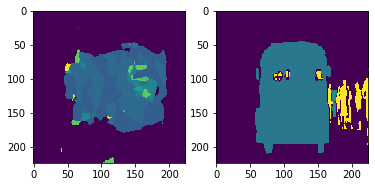

Classe prédite :  ['background', 'aeroplane', 'bus', 'car', 'cat', 'chair', 'diningtable', 'motorbike', 'person', 'pottedplant', 'sofa', 'train', 'tvmonitor']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
EPOCH 17
EPOCH 18
EPOCH 19
EPOCH 20


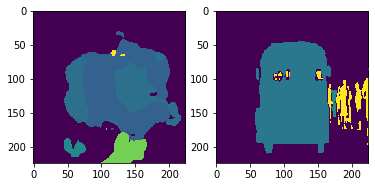

Classe prédite :  ['background', 'bicycle', 'bottle', 'bus', 'car', 'chair', 'person', 'train']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 21
EPOCH 22
EPOCH 23
EPOCH 24
EPOCH 25
EPOCH 26
EPOCH 27
EPOCH 28
EPOCH 29
EPOCH 30
EPOCH 31
EPOCH 32
EPOCH 33
EPOCH 34
EPOCH 35
EPOCH 36
EPOCH 37
EPOCH 38
EPOCH 39
EPOCH 40


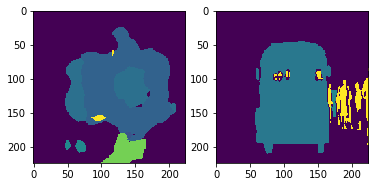

Classe prédite :  ['background', 'bottle', 'bus', 'car', 'chair', 'diningtable', 'person', 'train']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 41
EPOCH 42
EPOCH 43
EPOCH 44
EPOCH 45
EPOCH 46
EPOCH 47
EPOCH 48
EPOCH 49
EPOCH 50
EPOCH 51
EPOCH 52
EPOCH 53
EPOCH 54
EPOCH 55
EPOCH 56
EPOCH 57
EPOCH 58
EPOCH 59
EPOCH 60


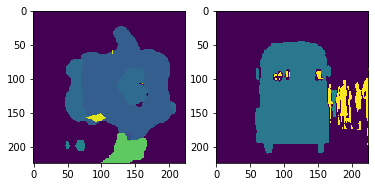

Classe prédite :  ['background', 'bottle', 'bus', 'car', 'chair', 'person', 'train', 'tvmonitor']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 61
EPOCH 62
EPOCH 63
EPOCH 64
EPOCH 65
EPOCH 66
EPOCH 67
EPOCH 68
EPOCH 69
EPOCH 70
EPOCH 71
EPOCH 72
EPOCH 73
EPOCH 74
EPOCH 75
EPOCH 76
EPOCH 77
EPOCH 78
EPOCH 79
EPOCH 80


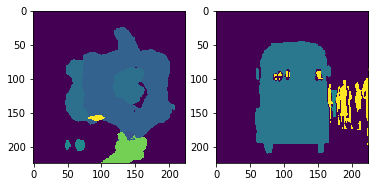

Classe prédite :  ['background', 'bottle', 'bus', 'car', 'chair', 'diningtable', 'person', 'train']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 81
EPOCH 82
EPOCH 83
EPOCH 84
EPOCH 85
EPOCH 86
EPOCH 87
EPOCH 88
EPOCH 89
EPOCH 90
EPOCH 91
EPOCH 92
EPOCH 93
EPOCH 94
EPOCH 95
EPOCH 96
EPOCH 97
EPOCH 98
EPOCH 99
EPOCH 100


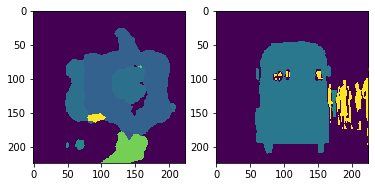

Classe prédite :  ['background', 'bottle', 'bus', 'car', 'chair', 'motorbike', 'person', 'train']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 101
EPOCH 102
EPOCH 103
EPOCH 104
EPOCH 105
EPOCH 106
EPOCH 107
EPOCH 108
EPOCH 109
EPOCH 110
EPOCH 111
EPOCH 112
EPOCH 113
EPOCH 114
EPOCH 115
EPOCH 116
EPOCH 117
EPOCH 118
EPOCH 119
EPOCH 120


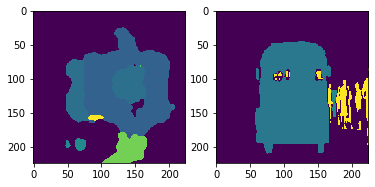

Classe prédite :  ['background', 'bottle', 'bus', 'car', 'chair', 'motorbike', 'person', 'train']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 121
EPOCH 122
EPOCH 123
EPOCH 124
EPOCH 125
EPOCH 126
EPOCH 127
EPOCH 128
EPOCH 129
EPOCH 130
EPOCH 131
EPOCH 132
EPOCH 133
EPOCH 134
EPOCH 135
EPOCH 136
EPOCH 137
EPOCH 138
EPOCH 139
EPOCH 140


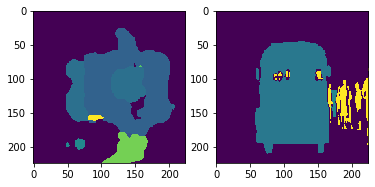

Classe prédite :  ['background', 'bottle', 'bus', 'car', 'chair', 'motorbike', 'person', 'train']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 141
EPOCH 142
EPOCH 143
EPOCH 144
EPOCH 145
EPOCH 146
EPOCH 147
EPOCH 148
EPOCH 149
EPOCH 150
EPOCH 151
EPOCH 152
EPOCH 153
EPOCH 154
EPOCH 155
EPOCH 156
EPOCH 157
EPOCH 158
EPOCH 159
EPOCH 160


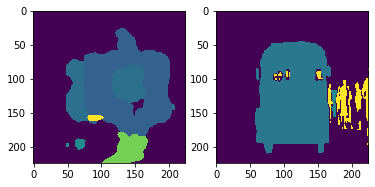

Classe prédite :  ['background', 'bottle', 'bus', 'car', 'chair', 'person', 'train']
Classe réelle :  ['background', 'bus', 'car', 'person']
EPOCH 161
EPOCH 162
EPOCH 163
EPOCH 164
EPOCH 165
EPOCH 166
EPOCH 167
EPOCH 168
EPOCH 169
EPOCH 170
EPOCH 171
EPOCH 172
EPOCH 173
EPOCH 174


In [0]:
SAVE_DIR = '/tmp/model'
iou_train = []
loss_train = []
iou_test = []
loss_test = []
all_loss_train = []
all_loss_test = []
all_iou = []
for ep in range(n_epochs):
    print("EPOCH",ep)

    for i,(x,mask) in enumerate(dataloader_train):
          x = x.to(device)
          mask = mask.to(device)

          fcn8.train()
          pred = fcn8(x)
          #pred = pred.squeeze()
          #mask = mask.squeeze()

          #print('i =',i)

          loss = criterion(pred,mask)
          all_loss_train.append(loss.item())
          loss.backward()

          all_iou.append(float(iou(pred.argmax(dim=1),mask)))

          optimizer.step()
          optimizer.zero_grad()

    loss_train.append(np.array(all_loss_train).mean()) #.item() pour eviter fuite memoire
    iou_train.append(np.array(all_iou).mean())
    all_loss_train = []
    all_iou = []
    for i,(x,mask) in enumerate(dataloader_val):
          x = x.to(device)
          mask = mask.to(device)

          fcn16.eval()
          with torch.no_grad():
            pred = fcn8(x)
          #pred = pred.squeeze()
          #mask = mask.squeeze()

          loss = criterion(pred,mask)
          all_loss_test.append(loss.item())
          all_iou.append(float(iou(pred.argmax(dim=1),mask)))
      
    loss_test.append(np.array(all_loss_test).mean())
    iou_test.append(np.array(all_iou).mean())
    all_loss_test = []
    all_iou = []

    if ep%20==0:
      try:
        i = 0
        fig = plt.figure()

        a = fig.add_subplot(1,2,1)
        plt.imshow(np.transpose(pred.argmax(dim=1)[i].cpu()))

        a = fig.add_subplot(1,2,2)
        plt.imshow(mask.cpu().detach().numpy()[i])

        plt.show()
        class_pred = []
        class_mask = []

        for p in pred.argmax(dim=1)[i].unique():
          class_pred.append(VOC_CLASSES[int(p)])
        for m in mask[i].unique():
          class_mask.append(VOC_CLASSES[int(m)])

        print("Classe prédite : ",class_pred)
        print("Classe réelle : ",class_mask)
      except:
        print('something with the plot image function')
        
    

In [0]:
torch.save(fcn8, '/content/drive/My Drive/segmentation/fcn8.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FCN8_VGG16. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
fcn8=torch.load('/content/drive/My Drive/segmentation/fcn8.pt')

### Plot 

Text(0, 0.5, 'Mean IOU')

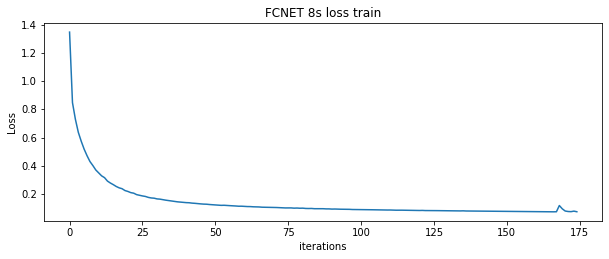

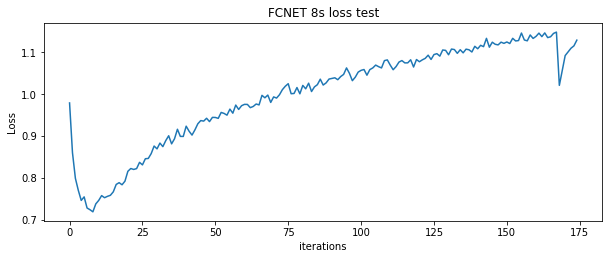

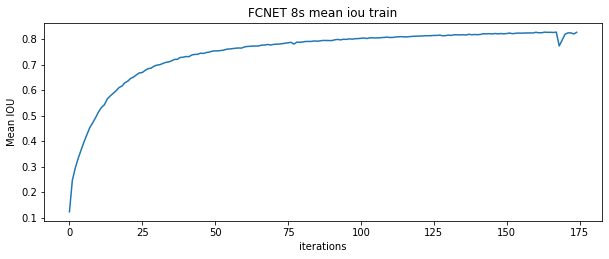

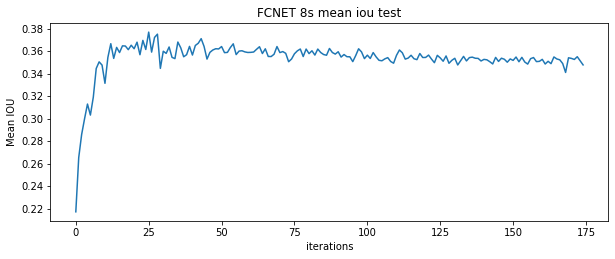

In [0]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 8s loss train")
plt.plot(loss_train)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 8s loss test")
plt.plot(loss_test)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 8s mean iou train")
plt.plot(iou_train)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 8s mean iou test")
plt.plot(iou_test)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")

In [0]:
evaluate_model(fcn8,dataloader_val)

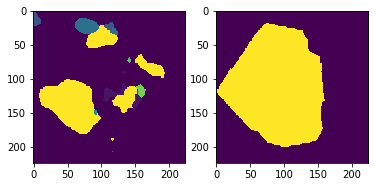

Classe prédite :  ['background', 'aeroplane', 'bottle', 'car', 'cat', 'cow', 'motorbike', 'person', 'train']
Classe réelle :  ['background', 'train']
0.7043407206632653
IOU sur ce masque : 0.30599290132522583


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [0]:
x,mask = next(iter(dataloader_val))
i = 3
x = x.to(device)
mask = mask.to(device)
pred = fcn8(x)
fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(pred.max(dim=1)[1][i].cpu())

a = fig.add_subplot(1,2,2)
plt.imshow(mask.cpu().detach().numpy()[i])

plt.show()

class_pred = []
class_mask = []

for p in pred.argmax(dim=1)[i].unique():
  class_pred.append(VOC_CLASSES[int(p)])
for m in mask[i].unique():
  class_mask.append(VOC_CLASSES[int(m)])

print("Classe prédite : ",class_pred)
print("Classe réelle : ",class_mask)
print(scores(pred.argmax(dim=1)[i],mask[i])["Pixel Accuracy"])
print("IOU sur ce masque :",float(iou(pred.argmax(dim=1)[i].unsqueeze(0),mask[i].unsqueeze(0))))
